# Set up

In [10]:

from typing import Dict, Tuple, List
from math import sqrt
from dataclasses import dataclass
from gurobipy import Model, GRB, tupledict, LinExpr, GurobiError
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

import numpy as np
import os
import re

from itertools import combinations

from graph_tool import Graph, EdgePropertyMap
from graph_tool.generation import complete_graph
from graph_tool.flow import boykov_kolmogorov_max_flow, min_st_cut

# Define classes

## Data loader

In [11]:
class TspDataLoader:
    """ Class to load and process data for TSP instances. """

    def __init__(self, dir='data'):
        self.dir = dir

    def load_problem(self, problem):
        """ Load a TSP problem and return its vertices count and cost matrix. """
        file_name = "data/"+problem

        # Read file content
        with open(file_name, 'r') as file:
            content = file.read()

        problem_type = problem.split('.')[-1]

        n = int(re.search(r'\d+', problem).group())
        # 64 is actually 65 
        if n == 64:
            n = 65

        # Process the file content
        data_lines = content.split('\n')

        try:
            start_index = data_lines.index('EDGE_WEIGHT_SECTION')
        except:
            start_index = data_lines.index('NODE_COORD_SECTION')
            
        # Extract the data lines after 'EDGE_WEIGHT_SECTION'
        edge_weight_lines = data_lines[start_index + 1:][:-2]

        # Parse the distance matrix (lines are not rows)
        if problem_type == 'atsp':
            distance_matrix = [list(map(int, line.split())) for line in edge_weight_lines if line.strip()]

            def flatten(l):
                return [item for sublist in l for item in sublist]

            distance_list = flatten(distance_matrix)
            print(len(distance_list))

            my_matrix = np.array(distance_list).reshape((n, n))
            my_matrix.shape
        else:
            try:
                print('has_index')
                ys = [ float(line.split(' ')[3])  for line in edge_weight_lines if line.strip()]
                xs = [ float(line.split(' ')[2])  for line in edge_weight_lines if line.strip()]
            except:
                ys = [ float(line.split(' ')[2])  for line in edge_weight_lines if line.strip()]
                xs = [ float(line.split(' ')[1])  for line in edge_weight_lines if line.strip()]

        for line in data_lines:
            if 'EDGE_WEIGHT_TYPE' in line:
                weight_type = line.split(':')[1].strip()
        print(weight_type)

        V = range(n)
        if problem_type == 'atsp':
            cost = {
                (i, j): my_matrix[i,j]
                for i in V for j in V if i != j
            }
        else:
            if weight_type == 'GEO':
                cost = {
                    (i, j): haversine_distance((xs[i], ys[i]), (xs[j], ys[j]))
                    for i in V for j in V if i != j
                }
            else:
                cost = {
                    (i, j): math.sqrt((xs[i] - xs[j]) ** 2 + (ys[i] - ys[j]) ** 2)
                    for i in V for j in V if i != j
                }

        # Initialize an array to store the 5 closest vertices for each vertex
        closest_vertices_array = []

        # For each vertex, find the 5 closest vertices and add to the array
        for i in V:
            sorted_vertices = sorted(V, key=lambda j: cost[i, j] if i != j else float('inf'))
            closest_vertices_array.append(sorted_vertices[1:6])  # Skip the first one (itself) and take the next five

        return n, cost, closest_vertices_array

## Integer solver

In [12]:
class TspInstance:
    """ An instance of the Travelling Salesman Problem. """

    def __init__(self, n_vertices, cost, closest_vertices_array = None, x=None, y=None):
        """
        Initialize a TSP instance.

        Parameters
        ----------
        n_vertices : int
            Number of vertices in the graph.
        cost : dict[tuple[int, int], float]
            Dictionary with arcs as key, and their corresponding costs as values.
        x : list[float], optional
            X coordinates of the vertices (for plotting).
        y : list[float], optional
            Y coordinates of the vertices (for plotting).
        """
        self.n_vertices = n_vertices
        self.cost = cost
        self.closest_vertices_array = closest_vertices_array if closest_vertices_array is not None else []
        self.x = x if x is not None else []
        self.y = y if y is not None else []
        
@dataclass
class TspSolution:
    """ Solution to an instance of the Travelling Salesman Problem.

        Attributes
        ----------
        instance: TspInstance
            Reference to the TSP instance being solved.
        tour: List[int]
            Ordered list of vertices visited (without repeating the first one).
        cost: float
            Travel cost of the tour.
    """

    instance: TspInstance
    tour: List[int]
    cost: float
    lazy_constraints_added: List[dict]
    model_metrics: Dict

    def plot(self) -> Tuple[Figure, plt.Axes]:
        """ Plots the solution of the TSP.
        
            Vertices are black dots, the solution is represented by red lines.

            Returns
            -------
            A tuple with the figure and axes object from matplotlib.    
        """

        xy = [(self.instance.x[i], self.instance.y[i]) for i in self.tour + [self.tour[0]]]

        fig, ax = plt.subplots(figsize=(10, 10))
        ax.scatter(self.instance.x, self.instance.y, color='black')
        
        for pt1, pt2 in zip(xy[1:], xy[:-1]):
            x1, y1 = pt1
            x2, y2 = pt2
            ax.plot([x1, x2], [y1, y2], color='red')

        ax.set_title(f"TSP Solution. Num vertices: {self.instance.n_vertices}. Tour cost: {self.cost:.2f}.")
        ax.set_axis_off()

        return fig, ax
    
class TspIntegerBCSolver:
    """ 
    Solver for the Travelling Salesman Problem using the branch-and-cut algorithm.

    This solver applies the Dantzig-Fulkerson-Johnson (DFJ) formulation of the TSP
    and focuses on separating subtour elimination constraints (SECs) only on integer solutions.

    Attributes:
    _instance : TspInstance
        The instance of the TSP to be solved.
    _V : List[int]
        List of vertex indices in the TSP instance.
    _A : List[Tuple[int, int]]
        List of arcs (edges between pairs of vertices) in the TSP instance.
    _model : Model
        The Gurobi model for the TSP instance.
    _x : tupledict
        Gurobi variables representing whether an arc is included in the tour.
    """

    def __init__(self, instance: TspInstance, cardinality=None, l = None):
        """
        Initializes the solver with a TSP instance and builds the model.

        Parameters:
        instance (TspInstance): The TSP instance to be solved.
        """
        # Store the TSP instance and create lists of vertices and arcs
        self._instance = instance
        self._V = list(range(self._instance.n_vertices))
        self._A = list(self._instance.cost.keys())
        self.lazy_constraints_added = []  # Initialize an empty list to store lazy constraints
        self.cardinality = cardinality  # Store the cardinality parameter
        self._L = l  # Contraint to be added for l closest vertices


        # Build the optimization model
        self.__build_model()


    def __build_model(self):
        """ 
        Builds the initial DFJ model for the TSP without subtour elimination constraints (SECs).
        """
        # Initialize the Gurobi model
        self._model = Model()
        
        # Set the time limit for the solver (in seconds)
        self._model.setParam(GRB.Param.TimeLimit, 300)  # 300 seconds = 5 minutes

        # Add variables representing whether each arc is included in the tour
        self._x = self._model.addVars(self._A, obj=self._instance.cost, vtype=GRB.BINARY, name='x')

    

        # Add constraints to ensure exactly one outgoing and one incoming arc for each vertex
        self._model.addConstrs((self._x.sum(i, '*') == 1 for i in self._V), name='outgoing')
        self._model.addConstrs((self._x.sum('*', i) == 1 for i in self._V), name='incoming')

        # Question 2: Add constraints to ensure x(i,j) + x(j,k)  <= 1
        if self.cardinality == 2.2 or self.cardinality == 2.3:
            self._model.addConstrs((self._x[i, j] + self._x[j, i] <= 1 for i in self._V for j in self._V if i != j), name='cardinality two')

        # Question 2: Add constraints to ensure x(i,j) + x(j,k) +x(k,i) <= 2
        if self.cardinality == 2.3:
            self._model.addConstrs((self._x[i, j] + self._x[j, k] + self._x[k, i]<= 2 for i in self._V for j in self._V for k in self._V if i != j and j != k and k != i), name='cardinality three')

        # Question 3 constraints of the type (2,L) 
        if self.cardinality == 3.2 or self.cardinality == 3.3 or self.cardinality ==3.4:

            # Add custom constraints for the closest l vertices
            for i in self._V:

                # Retrieve the l closest vertices to vertex i
                closest_vertices = self._instance.closest_vertices_array[i][:self._L]

                # Add constraints for each of the closest vertices
                for j in closest_vertices:
                    self._model.addConstr(self._x[i, j] + self._x[j, i] <= 1, name=f'closest_constraint_{i}_{j}')

        # Question 3 constraints of the type (3,L) 
        if self.cardinality ==3.3 or self.cardinality ==3.4:

            # Add custom constraints for the closest l vertices
            for i in self._V:

                # Retrieve the l closest vertices to vertex i
                closest_vertices = self._instance.closest_vertices_array[i][:self._L]

                # Add constraints for each of the closest vertices
                for j in closest_vertices:
                    for k in closest_vertices:
                        if k != j:
                            self._model.addConstr(self._x[i, j] + self._x[j, k] + self._x[k, i]<= 2, name=f'closest_constraint_{i}_{j}_{k}')

        # Question 3 constraints of the type (4,L) 
        if self.cardinality ==3.4:

            # Add custom constraints for the closest l vertices
            for i in self._V:

                # Retrieve the l closest vertices to vertex i
                closest_vertices = self._instance.closest_vertices_array[i][:self._L]

                # Add constraints for each of the closest vertices
                for j in closest_vertices:
                    for k in closest_vertices:
                            for z in closest_vertices:
                                if j != k and j != z and k != z:
                                    self._model.addConstr(self._x[i, j] + self._x[j, k] + self._x[k, z] + self._x[z, i] <= 3, name=f'closest_constraint_{i}_{j}_{k}_{z}')



    def __next_vertex(self, i: int) -> int:
        """
        Finds the next vertex in the current solution, starting from vertex i.

        Parameters:
        i (int): The starting vertex index.

        Returns:
        int: The index of the next vertex in the tour.
        """
        # Ensure the vertex index is valid
        assert 0 <= i < self._instance.n_vertices

        # Loop through all vertices to find the next one in the tour
        for j in self._V:
            if i != j:
                try:
                    # Inside a callback, retrieve the solution using cbGetSolution
                    val = self._model.cbGetSolution(self._x[i, j])
                except:
                    # Otherwise, access the variable's value directly
                    val = self._x[i, j].X

                # If the arc is part of the solution, return the next vertex
                if val > 0.5:
                    return j

        # If no successor is found, raise an error
        assert False, f"Vertex {j} has no successor?!"

    def __tour_staring_at(self, i: int) -> List[int]:
        """
        Constructs a tour (or subtour) starting at vertex i based on the current solution.

        Parameters:
        i (int): The starting vertex index.

        Returns:
        List[int]: A list of vertex indices representing the tour.
        """
        # Ensure the vertex index is valid
        assert 0 <= i < self._instance.n_vertices

        # Initialize the tour with the starting vertex
        tour = [i]
        current = self.__next_vertex(i)

        # Continue adding vertices to the tour until it loops back to the start
        while current != i:
            tour.append(current)
            current = self.__next_vertex(current)

        return tour

    def __add_sec_for(self, S: List[int]) -> None:
        """
        Adds a subtour elimination constraint (SEC) for the vertices in set S.

        Parameters:
        S (List[int]): A list of vertex indices forming a subtour.
        """
        # Ensure the subtour has a valid number of vertices
        assert 0 < len(S) < self._instance.n_vertices
   
        # Record the constraint information
        constraint_info = {
            'subtour': S,
            'constraint': sum(self._x[i, j] for (i, j) in self._A if i in S and j not in S) >= 1
        }

        self.lazy_constraints_added.append(constraint_info)
        
        # Add the actual lazy constraint to the model
        self._model.cbLazy(sum(self._x[i, j] for (i, j) in self._A if i in S and j not in S) >= 1)

    def __separate(self, where: int) -> None:
        """ Separates eventual violated SECs. """

        if where != GRB.Callback.MIPSOL:
            return
        
        # Set of vertices not yet placed in a tour
        remaining = set(self._V)

        while len(remaining) > 0:
            # Get any vertex in set `remaining`
            current = next(iter(remaining))

            # Get the subtour which includes the vertex
            subtour = self.__tour_staring_at(current)

            # If the tour visits all vertices, nothing to do
            if len(subtour) == self._instance.n_vertices:
                return

            # Otherwise, it's a subtour => Add a SEC
            self.__add_sec_for(subtour)

            # Update set `remaining`
            remaining -= set(subtour)

    def solve(self) -> TspSolution:
        """ Solves the TSP DFJ model and returns the solution.
        
            It throws a RuntimeError if Gurobi cannot solve the model to optimality.

            Returns
            -------
            A TspSolution object with details about the solution.
        """

        # We must set this parameter to use callbacks
        self._model.setParam(GRB.Param.LazyConstraints, 1)

        # Gurobi always passes two parameters to the callback: `model` and `where`
        self._model.optimize(lambda _, where: self.__separate(where))


        if self._model.Status != GRB.OPTIMAL:
            return "Solution not found"
        #    raise RuntimeError(f"Could not find the optimal solution. Gurobi status = {self._model.Status}")

        model_metrics = {} 
        for metric in ["NumVars", "ObjVal", "ObjBound", "IterCount", "SolCount", "NodeCount", "Runtime"]:
            model_metrics[metric] = self._model.getAttr(metric)

        return TspSolution(
            instance=self._instance,
            tour=self.__tour_staring_at(0),
            cost=self._model.ObjVal,
            model_metrics=model_metrics,
            lazy_constraints_added=self.lazy_constraints_added
        )
    

# Fractional solver

In [13]:
class TspFractionalBCSolver:
    """ Solver for the Travelling Salesman Problem.
    
        It uses the branch-and-cut algorithm applied to the "DFJ" formulation.
        Subtour elimination constraints are separated on integer and
        fractional solutions alike.
    """

    _EPS: float = 1e-6

    _instance: TspInstance
    _V: List[int]
    _A: List[Tuple[int, int]]
    _g: Graph
    _cap: EdgePropertyMap
    _model: Model
    _x: tupledict
    _L: int

    def __init__(self, instance: TspInstance, cardinality=None, l = None):
        """ Initialises the solver and builds the model.
        
            Parameters
            ----------
            instance: TspInstance
                The TSP instance.
        """
        self._L = l  # Contraint to be added for l closest vertices
        self._instance = instance
        self._V = list(range(self._instance.n_vertices))
        self._A = list(self._instance.cost.keys())
        self.lazy_constraints_added = []  # Initialize an empty list to store lazy constraints
        self.cardinality = cardinality  # Store the cardinality parameter
        self.__build_graph()
        self.__build_model()


    def __build_graph(self) -> None:
        """ Builds the graph for cut separation. """
        self._g = complete_graph(N=self._instance.n_vertices, self_loops=False, directed=True)
        self._cap = self._g.new_edge_property(value_type='double')
        self._g.edge_properties['cap'] = self._cap       

    def __build_model(self) -> None:
        """ Builds the DFJ model without SECs. """
         
        self._model = Model()
        # Set the time limit for the solver (in seconds)
        self._model.setParam(GRB.Param.TimeLimit, 300)  # 300 seconds = 5 minutes
        self._x = self._model.addVars(self._A, obj=self._instance.cost, vtype=GRB.BINARY, name='x')
        self._model.addConstrs((self._x.sum(i, '*') == 1 for i in self._V), name='outgoing')
        self._model.addConstrs((self._x.sum('*', i) == 1 for i in self._V), name='incoming')

        # Question 2: Add constraints to ensure x(i,j) + x(j,k)  <= 1
        if self.cardinality == 2.2 or self.cardinality == 2.3:
            self._model.addConstrs((self._x[i, j] + self._x[j, i] <= 1 for i in self._V for j in self._V if i != j), name='cardinality two')

        # Question 2: Add constraints to ensure x(i,j) + x(j,k) +x(k,i) <= 2
        if self.cardinality == 2.3:
            self._model.addConstrs((self._x[i, j] + self._x[j, k] + self._x[k, i]<= 2 for i in self._V for j in self._V for k in self._V if i != j and j != k and k != i), name='cardinality three')

        # Question 3 constraints of the type (2,L) 
        if self.cardinality == 3.2 or self.cardinality == 3.3 or self.cardinality ==3.4:

            # Add custom constraints for the closest l vertices
            for i in self._V:

                # Retrieve the l closest vertices to vertex i
                closest_vertices = self._instance.closest_vertices_array[i][:self._L]


                # Add constraints for each of the closest vertices
                for j in closest_vertices:
                    self._model.addConstr(self._x[i, j] + self._x[j, i] <= 1, name=f'closest_constraint_{i}_{j}')

        # Question 3 constraints of the type (3,L)
        if self.cardinality == 3.3 or self.cardinality == 3.4:
            # Add custom constraints for the closest l vertices
            for i in self._V:
                # Retrieve the l closest vertices to vertex i
                closest_vertices = self._instance.closest_vertices_array[i][:self._L]

                # Add constraints for each of the closest vertices
                for j in closest_vertices:
                    for k in closest_vertices:
                        if k != j:
                            self._model.addConstr(self._x[i, j] + self._x[j, k] + self._x[k, i] <= 2, name=f'closest_constraint_{i}_{j}_{k}')

        # Question 3 constraints of the type (4,L) 
        if self.cardinality ==3.4:

            # Add custom constraints for the closest l vertices
            for i in self._V:

                # Retrieve the l closest vertices to vertex i
                closest_vertices = self._instance.closest_vertices_array[i][:self._L]

                # Add constraints for each of the closest vertices
                for j in closest_vertices:
                    for k in closest_vertices:
                            for z in closest_vertices:
                                if j != k and j != z and k != z:
                                    self._model.addConstr(self._x[i, j] + self._x[j, k] + self._x[k, z] + self._x[z, i] <= 3, name=f'closest_constraint_{i}_{j}_{k}_{z}')

    def __next_vertex(self, i: int) -> int:
        """ Gets the vertex visited immediately after i in the current TSP solution.

            This is the (only) vertex j such that x[i,j] == 1. This function works both
            when inside a callback (when the value of x must be retrieved via cbGetSolution)
            and after the optimisation is over (when the value of X can be accessed via X).
        """

        assert 0 <= i < self._instance.n_vertices

        for j in self._V:
            if i != j:
                try:
                    # If inside a call-back, we use cbGetSolution
                    val = self._model.cbGetSolution(self._x[i, j])
                except:
                    # Otherwise we use .X
                    val = self._x[i, j].X

                if val > 0.5:
                    return j

        assert False, f"Vertex {j} has no successor?!"

    def __tour_staring_at(self, i: int) -> List[int]:
        """ Gives the (sub)tour starting at a given vertex i in the current TSP solution. """

        assert 0 <= i < self._instance.n_vertices

        tour = [i]
        current = self.__next_vertex(i)

        while current != i:
            tour.append(current)
            current = self.__next_vertex(current)

        return tour

    def __add_sec_for(self, S: List[int]) -> None:
        """ Adds a Subtour Elimination Constraint for set S. """

        assert 0 < len(S) < self._instance.n_vertices

        self._model.cbLazy(sum(self._x[i, j] for (i, j) in self._A if i in S and j not in S) >= 1)

        # Record the constraint information
        constraint_info = {
            'subtour': S,
            'constraint': sum(self._x[i, j] for (i, j) in self._A if i in S and j not in S) >= 1
        }

        self.lazy_constraints_added.append(constraint_info)

    def __set_capacity(self) -> None:
        """ Sets graph capacity based on current solution. """

        for e in self._g.edges():
            i, j = e.source(), e.target()

            try: # If we are in MIPSOL
                xval = self._model.cbGetSolution(self._x[i,j])
            except: # If we are in MIPNODE
                xval = self._model.cbGetNodeRel(self._x[i,j])

            self._cap[e] = xval

    def __separate(self, where: int) -> None:
        """ Separates eventual violated SECs. """

        if where not in [GRB.Callback.MIPSOL, GRB.Callback.MIPNODE]:
            return

        # In MIPNODE, we must ensure that we have the optimal solution to the
        # linear relaxation at that node. Otherwise we are not "authorised"
        # to call cbGetNodeRel. See:
        # https://www.gurobi.com/documentation/9.1/refman/py_model_cbgetnoderel.html
        if where == GRB.Callback.MIPNODE and self._model.cbGet(GRB.Callback.MIPNODE_STATUS) != GRB.OPTIMAL:
            return
        
        self.__set_capacity()

        source = self._g.vertex(0)
        already_added = set()

        print('Separation round!')

        for i in range(1, self._instance.n_vertices):
            if i in already_added:
                continue

            target = self._g.vertex(i)
            residual = boykov_kolmogorov_max_flow(
                g=self._g, source=source, target=target,
                capacity=self._cap
            )
            
            flow = residual.copy()
            flow.a = self._cap.a - residual.a

            total_flow = sum(flow[a] for a in target.in_edges())

            if total_flow < 1 - self._EPS: # Avoid numerical issues
                print(f"\tFound a subset which violate a SEC (flow = {total_flow:.3f} < 1)")
                
                cut = min_st_cut(g=self._g, source=source,capacity=self._cap, residual=residual)

                assert cut[source] == True
                assert cut[target] == False

                subtour = [j for j in self._V if cut[self._g.vertex(j)] == False]

                assert len(subtour) < self._instance.n_vertices

                print(f"\tSet size: {len(subtour)}")

                self.__add_sec_for(subtour)

                already_added = already_added.union(subtour)

    def solve(self) -> TspSolution:
        """ Solves the TSP DFJ model and returns the solution.
        
            It throws a RuntimeError if Gurobi cannot solve the model to optimality.

            Returns
            -------
            A TspSolution object with details about the solution.
        """

        # We must set this parameter to use callbacks
        self._model.setParam(GRB.Param.LazyConstraints, 1)

        # Gurobi always passes two parameters to the callback: `model` and `where`
        self._model.optimize(lambda _, where: self.__separate(where))

        if self._model.Status != GRB.OPTIMAL:
            return "Solution not found"
        #    raise RuntimeError(f"Could not find the optimal solution. Gurobi status = {self._model.Status}")

        model_metrics = {} 
        for metric in ["NumVars", "ObjVal", "ObjBound", "IterCount", "SolCount", "NodeCount", "Runtime"]:
            model_metrics[metric] = self._model.getAttr(metric)

        return TspSolution(
            instance=self._instance,
            tour=self.__tour_staring_at(0),
            cost=self._model.ObjVal,
            model_metrics=model_metrics,
            lazy_constraints_added=self.lazy_constraints_added
        )
    

# Question 1

In [14]:
# Load data set 1
tsp_loader = TspDataLoader()
#n_vertices, cost, closest_vertices_array = tsp_loader.load_problem('rbg323.atsp')
n_vertices, cost, closest_vertices_array = tsp_loader.load_problem('rbg443.atsp')

196249
EXPLICIT


### Solve with interger method

In [15]:
# interger
from tqdm import tqdm

# Output time and objective value for different number of vertices
#vertices_list = range(23, 324, 25)
vertices_list = range(43, 443, 50)

# Integer
time_list, objective_list, nrows_list, sol_list, iter_list, nvars_list = list(), list(), list(), list(), list(), list()
for vert in tqdm(vertices_list):
    filtered_vertices = vert
    filtered_cost = {(i, j): cost_val for (i, j), cost_val in cost.items() if i < filtered_vertices and j < filtered_vertices}

    i = TspInstance(n_vertices=filtered_vertices, cost=filtered_cost)
    s = TspIntegerBCSolver(instance=i, cardinality=None)
    sol = s.solve()

    time_list.append(s._model.Runtime)
    objective_list.append(s._model.ObjVal)
    nrows_list.append(s._model.NumConstrs)
    sol_list.append(sol.model_metrics['SolCount'])
    iter_list.append(sol.model_metrics['IterCount'])
    nvars_list.append(sol.model_metrics['NumVars'])

time_list_int, objective_list_int, nrows_list_int, sol_list_int, iter_list_int, nvars_list_int = time_list, objective_list, nrows_list, sol_list, iter_list, nvars_list

print("INTEGER FINISHED!!!")

  0%|          | 0/8 [00:00<?, ?it/s]

Set parameter TimeLimit to value 300
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 86 rows, 1806 columns and 3612 nonzeros
Model fingerprint: 0xfc6fed70
Variable types: 0 continuous, 1806 integer (1806 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 86 rows, 1806 columns, 3612 nonzeros
Variable types: 0 continuous, 1806 integer (1806 binary)

Root relaxation: objective 3.970000e+02, 187 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  397.00000    0    -          -  397.00000      -     -    0s
     0

 12%|█▎        | 1/8 [00:00<00:01,  5.08it/s]

Set parameter TimeLimit to value 300
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 186 rows, 8556 columns and 17112 nonzeros
Model fingerprint: 0x6fbb80bc
Variable types: 0 continuous, 8556 integer (8556 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 186 rows, 8556 columns, 17112 nonzeros
Variable types: 0 continuous, 8556 integer (8556 binary)

Root relaxation: objective 5.640000e+02, 462 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  564.00000    0    -          -  564.00000      -     -    0s
* 

 25%|██▌       | 2/8 [00:00<00:01,  3.58it/s]

Set parameter TimeLimit to value 300
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 286 rows, 20306 columns and 40612 nonzeros
Model fingerprint: 0xe8480751
Variable types: 0 continuous, 20306 integer (20306 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.04s
Presolved: 286 rows, 20306 columns, 40612 nonzeros
Variable types: 0 continuous, 20306 integer (20306 binary)

Root relaxation: objective 9.070000e+02, 868 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  907.00000    0    -          -  907.00000      -     -   

 38%|███▊      | 3/8 [00:04<00:08,  1.74s/it]

Set parameter TimeLimit to value 300
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 386 rows, 37056 columns and 74112 nonzeros
Model fingerprint: 0xd887c2f1
Variable types: 0 continuous, 37056 integer (37056 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.06s
Presolved: 386 rows, 37056 columns, 74112 nonzeros
Variable types: 0 continuous, 37056 integer (37056 binary)

Root relaxation: objective 1.196000e+03, 1278 iterations, 0.07 seconds (0.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1196.00000    0    -          - 1196.00000      -     -  

 50%|█████     | 4/8 [00:08<00:11,  2.79s/it]

Set parameter TimeLimit to value 300
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 486 rows, 58806 columns and 117612 nonzeros
Model fingerprint: 0x6da57d8e
Variable types: 0 continuous, 58806 integer (58806 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.11s
Presolved: 486 rows, 58806 columns, 117612 nonzeros
Variable types: 0 continuous, 58806 integer (58806 binary)

Root relaxation: objective 1.645000e+03, 1654 iterations, 0.10 seconds (0.10 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1645.00000    0    -          - 1645.00000      -     -

 62%|██████▎   | 5/8 [00:17<00:15,  5.04s/it]

Set parameter TimeLimit to value 300
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 586 rows, 85556 columns and 171112 nonzeros
Model fingerprint: 0x4931b378
Variable types: 0 continuous, 85556 integer (85556 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.13s
Presolved: 586 rows, 85556 columns, 171112 nonzeros
Variable types: 0 continuous, 85556 integer (85556 binary)

Root relaxation: objective 1.807000e+03, 1759 iterations, 0.14 seconds (0.15 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1807.00000    0    -          - 1807.00000      -     -

 75%|███████▌  | 6/8 [00:29<00:15,  7.57s/it]

Set parameter TimeLimit to value 300
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 686 rows, 117306 columns and 234612 nonzeros
Model fingerprint: 0x14b563ff
Variable types: 0 continuous, 117306 integer (117306 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.24s
Presolved: 686 rows, 117306 columns, 234612 nonzeros
Variable types: 0 continuous, 117306 integer (117306 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.860000e+02   0.000000e+00      5s
    2521    2.0710000e+03   0.000000e+00   0.000000e+00      6s

Root relaxation: objective 2.071000e+03, 2521 iterations, 0.33 seconds (0.37 work units)


 88%|████████▊ | 7/8 [00:47<00:10, 10.98s/it]

Set parameter TimeLimit to value 300
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 786 rows, 154056 columns and 308112 nonzeros
Model fingerprint: 0x2d4a9105
Variable types: 0 continuous, 154056 integer (154056 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.27s
Presolved: 786 rows, 154056 columns, 308112 nonzeros
Variable types: 0 continuous, 154056 integer (154056 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.860000e+02   0.000000e+00      8s
    3069    2.3830000e+03   0.000000e+00   0.000000e+00      9s

Root relaxation: objective 2.383000e+03, 3069 iterations, 0.84 seconds (0.42 work units)


100%|██████████| 8/8 [01:39<00:00, 12.43s/it]

INTEGER FINISHED!!!


### Solve with fractional method

In [19]:
# Fractional
time_list_frac, objective_list_frac, nrows_list_frac, sol_list_frac, iter_list_frac, nvars_list_frac = list(), list(), list(), list(), list(), list()
for vert in tqdm(vertices_list):
    filtered_vertices = vert
    filtered_cost = {(i, j): cost_val for (i, j), cost_val in cost.items() if i < filtered_vertices and j < filtered_vertices}

    i = TspInstance(n_vertices=filtered_vertices, cost=filtered_cost)
    s = TspFractionalBCSolver(instance=i, cardinality=None)
    sol = s.solve()

    if sol == 'Solution not found':

        time_list.append(300)
        objective_list.append(0)
        nrows_list.append(0)
        sol_list.append(0)
        iter_list.append(0)
        nvars_list.append(0)
    else :
        time_list.append(s._model.Runtime)
        objective_list.append(s._model.ObjVal)
        nrows_list.append(s._model.NumConstrs)
        sol_list.append(sol.model_metrics['SolCount'])
        iter_list.append(sol.model_metrics['IterCount'])
        nvars_list.append(sol.model_metrics['NumVars'])

time_list_frac, objective_list_frac, nrows_list_frac, sol_list_frac, iter_list_frac, nvars_list_frac = time_list, objective_list, nrows_list, sol_list, iter_list, nvars_list

  0%|          | 0/8 [00:00<?, ?it/s]

Set parameter TimeLimit to value 300
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 86 rows, 1806 columns and 3612 nonzeros
Model fingerprint: 0xfc6fed70
Variable types: 0 continuous, 1806 integer (1806 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Separation round!
	Found a subset which violate a SEC (flow = 0.000 < 1)
	Set size: 30
Presolve time: 0.01s
Presolved: 86 rows, 1806 columns, 3612 nonzeros
Variable types: 0 continuous, 1806 integer (1806 binary)
Separation round!
	Found a subset which violate a SEC (flow = 0.000 < 1)
	Set size: 41

Root relaxation: objective 3.970000e+02, 170 iterations, 0.00 seconds (0.00 work units)
Separation round!
	Found a subset which violate a SEC (flow

 12%|█▎        | 1/8 [00:00<00:05,  1.27it/s]

Set parameter TimeLimit to value 300
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 186 rows, 8556 columns and 17112 nonzeros
Model fingerprint: 0x6fbb80bc
Variable types: 0 continuous, 8556 integer (8556 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Separation round!
	Found a subset which violate a SEC (flow = 0.000 < 1)
	Set size: 25
Presolve time: 0.02s
Presolved: 186 rows, 8556 columns, 17112 nonzeros
Variable types: 0 continuous, 8556 integer (8556 binary)
Separation round!
	Found a subset which violate a SEC (flow = 0.000 < 1)
	Set size: 91

Root relaxation: objective 5.640000e+02, 444 iterations, 0.01 seconds (0.01 work units)
Separation round!
	Found a subset which violate a SEC (

 25%|██▌       | 2/8 [00:06<00:21,  3.60s/it]

Set parameter TimeLimit to value 300
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 286 rows, 20306 columns and 40612 nonzeros
Model fingerprint: 0xe8480751
Variable types: 0 continuous, 20306 integer (20306 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Separation round!
	Found a subset which violate a SEC (flow = 0.000 < 1)
	Set size: 51
Presolve time: 0.06s
Presolved: 286 rows, 20306 columns, 40612 nonzeros
Variable types: 0 continuous, 20306 integer (20306 binary)
Separation round!
	Found a subset which violate a SEC (flow = 0.000 < 1)
	Set size: 141

Root relaxation: objective 9.070000e+02, 981 iterations, 0.05 seconds (0.05 work units)
Separation round!
	Found a subset which violate 

 38%|███▊      | 3/8 [00:17<00:35,  7.17s/it]

Set parameter TimeLimit to value 300
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 386 rows, 37056 columns and 74112 nonzeros
Model fingerprint: 0xd887c2f1
Variable types: 0 continuous, 37056 integer (37056 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Separation round!
	Found a subset which violate a SEC (flow = 0.000 < 1)
	Set size: 158
Presolve time: 0.07s
Presolved: 386 rows, 37056 columns, 74112 nonzeros
Variable types: 0 continuous, 37056 integer (37056 binary)
Separation round!
	Found a subset which violate a SEC (flow = 0.000 < 1)
	Set size: 191

Root relaxation: objective 1.196000e+03, 1171 iterations, 0.05 seconds (0.05 work units)
Separation round!
	Found a subset which violat

 50%|█████     | 4/8 [02:00<02:58, 44.74s/it]

Set parameter TimeLimit to value 300
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 486 rows, 58806 columns and 117612 nonzeros
Model fingerprint: 0x6da57d8e
Variable types: 0 continuous, 58806 integer (58806 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Separation round!
	Found a subset which violate a SEC (flow = 0.000 < 1)
	Set size: 4
Presolve time: 0.11s
Presolved: 486 rows, 58806 columns, 117612 nonzeros
Variable types: 0 continuous, 58806 integer (58806 binary)
Separation round!
	Found a subset which violate a SEC (flow = 0.000 < 1)
	Set size: 241

Root relaxation: objective 1.645000e+03, 1522 iterations, 0.16 seconds (0.10 work units)
Separation round!
	Found a subset which violat

 62%|██████▎   | 5/8 [03:04<02:35, 51.79s/it]

Set parameter TimeLimit to value 300
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 586 rows, 85556 columns and 171112 nonzeros
Model fingerprint: 0x4931b378
Variable types: 0 continuous, 85556 integer (85556 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Separation round!
	Found a subset which violate a SEC (flow = 0.000 < 1)
	Set size: 119
Presolve time: 0.18s
Presolved: 586 rows, 85556 columns, 171112 nonzeros
Variable types: 0 continuous, 85556 integer (85556 binary)
Separation round!
	Found a subset which violate a SEC (flow = 0.000 < 1)
	Set size: 291

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.860000e+02   0.000

 75%|███████▌  | 6/8 [04:35<02:10, 65.23s/it]

Set parameter TimeLimit to value 300
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 686 rows, 117306 columns and 234612 nonzeros
Model fingerprint: 0x14b563ff
Variable types: 0 continuous, 117306 integer (117306 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Separation round!
	Found a subset which violate a SEC (flow = 0.000 < 1)
	Set size: 195
Presolve time: 0.18s
Presolved: 686 rows, 117306 columns, 234612 nonzeros
Variable types: 0 continuous, 117306 integer (117306 binary)
Separation round!
	Found a subset which violate a SEC (flow = 0.000 < 1)
	Set size: 341

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.860000e+02  

### Output table

In [ ]:
import pandas as pd


int_df = pd.DataFrame({'time': time_list_int, 'obj': objective_list_int, 'rows': nrows_list_int, 'iter': iter_list_int})
int_df['type'] = 'integer'

frac_df = pd.DataFrame({'time': time_list_frac, 'obj': objective_list_frac, 'rows': nrows_list_frac, 'iter': iter_list_frac})
frac_df['type'] = 'fractional'


pd.concat([int_df, frac_df], axis='rows').to_csv('question 1.csv')

latex_table_temp = pd.concat([int_df, frac_df], axis='rows')
latex_table = latex_table_temp.to_latex(index = False)

### Graphing time taken to solve

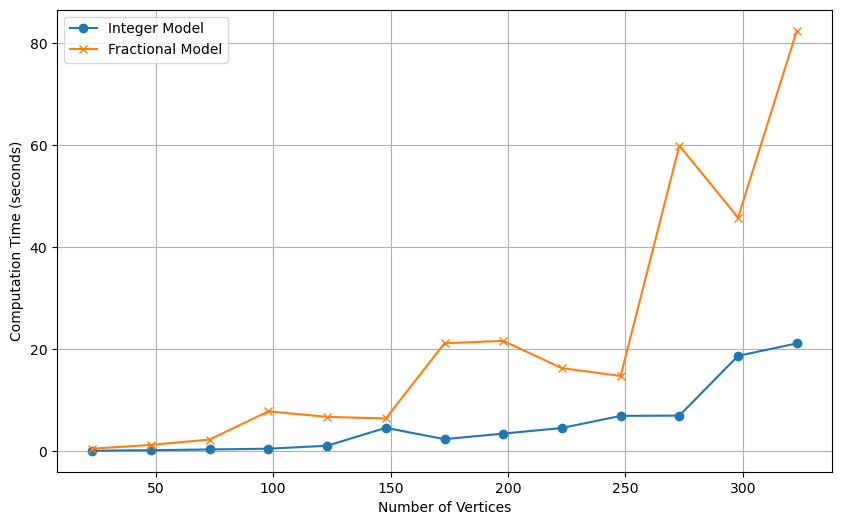

In [ ]:
# Plotting the graph of computational time
plt.figure(figsize=(10, 6))
plt.plot(vertices_list, time_list_int, marker='o', label = 'Integer Model')
plt.plot(vertices_list, time_list_frac, marker='x', label = 'Fractional Model')
plt.xlabel('Number of Vertices')
plt.ylabel('Computation Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

# Question 2
### Integer Implementation

In [ ]:
i_2 = TspInstance(n_vertices=filtered_vertices, cost=filtered_cost)
s_2 = TspIntegerBCSolver(instance=i_2, cardinality=2.3)
solution = s_2.solve()

Set parameter TimeLimit to value 10
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10990778 rows, 49506 columns and 33020502 nonzeros
Model fingerprint: 0x275c95b4
Variable types: 0 continuous, 49506 integer (49506 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 0 rows and 0 columns (presolve time = 6s) ...
Presolve time: 5.98s

Explored 0 nodes (0 simplex iterations) in 10.59 seconds (3.33 work units)
Thread count was 1 (of 8 available processors)

Solution count 0

Time limit reached
Best objective -, best bound -, gap -

User-callback calls 53, time in user-callback 0.43 sec


In [33]:
# Output time and objective value for different number of vertices
time_list_none = time_list_int
time_list_2 = list()
time_list_3 = list()

objective_list_none = objective_list_int
objective_list_2 = list()
objective_list_3 = list()

nrows_list_none = nrows_list_int
nrows_list_2 = list()
nrows_list_3 = list()

iter_list_none = iter_list_int
iter_list_2 = list()
iter_list_3 = list()


for vert in vertices_list:
    filtered_vertices = vert
    filtered_cost = {(i, j): cost_val for (i, j), cost_val in cost.items() if i < filtered_vertices and j < filtered_vertices}

    i_2 = TspInstance(n_vertices=filtered_vertices, cost=filtered_cost)
    s_2 = TspIntegerBCSolver(instance=i_2, cardinality=2.2)
    solution_2 = s_2.solve()

    if solution_2 == 'Solution not found':
        time_list_2.append(300)
        objective_list_2.append(0)
        nrows_list_2.append(0)
        iter_list_2.append(0)
    else:
        time_list_2.append(s_2._model.Runtime)
        objective_list_2.append(s_2._model.ObjVal)
        nrows_list_2.append(s_2._model.NumConstrs)
        iter_list_2.append(solution_2.model_metrics['IterCount'])
    
    i_3 = TspInstance(n_vertices=filtered_vertices, cost=filtered_cost)
    s_3 = TspFractionalBCSolver(instance=i_3, cardinality=2.3)
    solution_3 = s_3.solve()

    if solution_3 == 'Solution not found':
        time_list_3.append(300)
        objective_list_3.append(0)
        nrows_list_3.append(0)
        iter_list_3.append(0)
    else:
        time_list_3.append(s_3._model.Runtime)
        objective_list_3.append(s_3._model.ObjVal)
        nrows_list_3.append(s_3._model.NumConstrs)
        iter_list_3.append(solution_3.model_metrics['IterCount'])

Set parameter TimeLimit to value 10
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 552 rows, 506 columns and 2024 nonzeros
Model fingerprint: 0x103038f0
Variable types: 0 continuous, 506 integer (506 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 253 rows and 0 columns
Presolve time: 0.02s
Presolved: 299 rows, 506 columns, 1518 nonzeros
Variable types: 0 continuous, 506 integer (506 binary)

Root relaxation: objective 2.590000e+02, 78 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  259.00000    0    -          -  2

### Output to table

In [ ]:
int_no_cons = pd.DataFrame({'time': time_list_int, 'obj': objective_list_int, 'rows': nrows_list_int, 'iter': iter_list_int})
int_no_cons['type'] = 'integer'

int_card_2 = pd.DataFrame({'time': time_list_2, 'obj': objective_list_2, 'rows': nrows_list_2, 'iter': iter_list_2})
int_card_2 ['type'] = 'integer'


int_card_3 = pd.DataFrame({'time': time_list_3, 'obj': objective_list_3, 'rows': nrows_list_3, 'iter': iter_list_3})
int_card_3 ['type'] = 'integer'


pd.concat([int_no_cons, int_card_2, int_card_3], axis='rows').to_csv('question 2 - int.csv')

latex_table_temp = pd.concat([int_no_cons, int_card_2, int_card_3]
latex_table_2_int = latex_table_temp.to_latex(index = False)

### Graph computational time

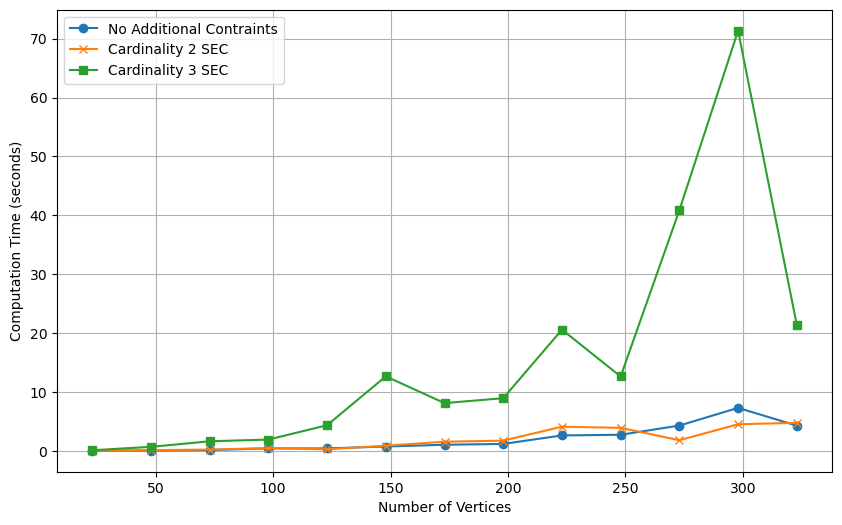

In [ ]:
# Plotting the graph of computational time
plt.figure(figsize=(10, 6))
plt.plot(vertices_list, time_list_none, marker='o', label = "No Additional Contraints")
plt.plot(vertices_list, time_list_2, marker='x', label = "Cardinality 2 SEC")
plt.plot(vertices_list, time_list_3, marker='s', label = "Cardinality 3 SEC")
plt.xlabel('Number of Vertices')
plt.ylabel('Computation Time (seconds)')
#plt.title('Computation Time vs Number of Vertices in TSP')
plt.legend()
plt.grid(True)
plt.show()


for i in range(len(objective_list_none)):
        
        assert objective_list_none[i]==objective_list_2[i]

### Fractional

In [ ]:
time_list_none_f = time_list_frac
time_list_2_f = list()
time_list_3_f = list()

objective_list_none_f = objective_list_frac
objective_list_2_f = list()
objective_list_3_f = list()

nrows_list_none_f = nrows_list_frac
nrows_list_2_f = list()
nrows_list_3_f = list()

iter_list_none_f = iter_list_frac
iter_list_2_f = list()
iter_list_3_f= list()

for vert in vertices_list:
    filtered_vertices = vert
    filtered_cost = {(i, j): cost_val for (i, j), cost_val in cost.items() if i < filtered_vertices and j < filtered_vertices}

    i_2 = TspInstance(n_vertices=filtered_vertices, cost=filtered_cost)
    s_2 = TspFractionalBCSolver(instance=i_2, cardinality=2.2)
    solution_2 = s_2.solve()

    if solution_2 == 'Solution not found':
        time_list_2_f.append(300)
        objective_list_2_f.append(0)
        nrows_list_2_f.append(0)
        iter_list_2_f.append(0)
    else:
        time_list_2_f.append(s_2._model.Runtime)
        objective_list_2_f.append(s_2._model.ObjVal)
        nrows_list_2_f.append(s_2._model.NumConstrs)
        iter_list_2_f.append(solution_2.model_metrics['IterCount'])
          
    i_3 = TspInstance(n_vertices=filtered_vertices, cost=filtered_cost)
    s_3 = TspFractionalBCSolver(instance=i_3, cardinality=2.3)
    solution_3 = s_3.solve()

    if solution_3 == 'Solution not found':
        time_list_3_f.append(300)
        objective_list_3_f.append(0)
        nrows_list_3_f.append(0)
        iter_list_3_f.append(0)
    else:
        time_list_3_f.append(s_3._model.Runtime)
        objective_list_3_f.append(s_3._model.ObjVal)
        nrows_list_3_f.append(s_3._model.NumConstrs)
        iter_list_3_f.append(solution_3.model_metrics['IterCount'])

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 552 rows, 506 columns and 2024 nonzeros
Model fingerprint: 0xb009aa87
Variable types: 0 continuous, 506 integer (506 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Separation round!
	Found a subset which violate a SEC (flow = 0.000 < 1)
	Set size: 7
Presolve removed 253 rows and 0 columns
Presolve time: 0.00s
Presolved: 299 rows, 506 columns, 1518 nonzeros
Variable types: 0 continuous, 506 integer (506 binary)
Separation round!
	Found a subset which violate a SEC (flow = 0.000 < 1)
	Set size: 19

Root relaxation: objective 1.920000e+02, 66 iterations, 0.00 seconds (0.00 work units)
Separation round!
	Found a subset which violate a SEC (flow = 0.000

: 

### Output to table

In [ ]:
frac_no_cons = pd.DataFrame({'time': time_list_frac, 'obj': objective_list_frac, 'rows': nrows_list_frac, 'iter': iter_list_frac})
frac_no_cons['type'] = 'integer'

frac_card_2 = pd.DataFrame({'time': time_list_2_f, 'obj': objective_list_2_f, 'rows': nrows_list_2_f, 'iter': iter_list_2_f})
frac_card_2 ['type'] = 'integer'


frac_card_3 = pd.DataFrame({'time': time_list_3_f, 'obj': objective_list_3_f, 'rows': nrows_list_3_f, 'iter': iter_list_3_f})
frac_card_3 ['type'] = 'integer'


pd.concat([frac_no_cons, frac_card_2, frac_card_3], axis='rows').to_csv('question 2 - frac.csv')

latex_table_temp = pd.concat([frac_no_cons, frac_card_2, frac_card_3]
latex_table_2_int = latex_table_temp.to_latex(index = False)

### Graph

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(vertices_list, time_list_none_f, marker='o', label = "No Additional Contraints")
plt.plot(vertices_list, time_list_2_f, marker='x', label = "Cardinality 2 SEC")
plt.plot(vertices_list, time_list_3_f, marker='s', label = "Cardinality 3 SEC")
plt.xlabel('Number of Vertices')
plt.ylabel('Computation Time (seconds)')
#plt.title('Computation Time vs Number of Vertices in TSP')
plt.legend()
plt.grid(True)
plt.show()



for i in range(len(objective_list_none_f)):
        
        assert objective_list_none_f[i]==objective_list_2_f[i]

NameError: name 'plt' is not defined

In [ ]:
for i in range(len(objective_list_none_f)):
        
        assert objective_list_none_f[i]==objective_list_2_f[i]

In [ ]:
# Check how many times cardinality constraints where violated
for entry in s.lazy_constraints_added:
    subtour = entry['subtour']
    constraint = entry['constraint']
    
    # Check if the subtour length is exactly 2
    if len(subtour) == 2:
        # The subtour contains exactly two vertices i and j
        i, j = subtour
        # The corresponding constraint is for i to j and j to i
        print(f"Lazy constraint for subtour {subtour}")


Lazy constraint for subtour [35, 264]
Lazy constraint for subtour [0, 322]
Lazy constraint for subtour [1, 321]
Lazy constraint for subtour [2, 320]
Lazy constraint for subtour [3, 319]
Lazy constraint for subtour [4, 318]
Lazy constraint for subtour [5, 317]
Lazy constraint for subtour [6, 316]
Lazy constraint for subtour [7, 315]
Lazy constraint for subtour [8, 314]
Lazy constraint for subtour [9, 313]
Lazy constraint for subtour [10, 312]
Lazy constraint for subtour [11, 311]
Lazy constraint for subtour [12, 310]
Lazy constraint for subtour [13, 309]
Lazy constraint for subtour [14, 308]
Lazy constraint for subtour [15, 307]
Lazy constraint for subtour [16, 306]
Lazy constraint for subtour [17, 305]
Lazy constraint for subtour [18, 304]
Lazy constraint for subtour [19, 303]
Lazy constraint for subtour [20, 302]
Lazy constraint for subtour [21, 301]
Lazy constraint for subtour [22, 300]
Lazy constraint for subtour [23, 299]
Lazy constraint for subtour [24, 298]
Lazy constraint for su

In [ ]:
# Check how many times cardinality constraints where violated
for entry in s.lazy_constraints_added:
    subtour = entry['subtour']
    constraint = entry['constraint']
    

    # Check if the subtour length is exactly 2
    if len(subtour) == 3:
        # The subtour contains exactly two vertices i and j
        i, j, k = subtour
        # The corresponding constraint is for i to j and j to i
        print(f"Lazy constraint for subtour {subtour}")

Lazy constraint for subtour [45, 88, 110]
Lazy constraint for subtour [162, 195, 275]
Lazy constraint for subtour [160, 161, 162]
Lazy constraint for subtour [0, 317, 316]
Lazy constraint for subtour [1, 308, 306]


# Question 3

## Integer

In [ ]:
# Load data set 1
tsp_loader = TspDataLoader()
n_vertices, cost, closest_vertices_array = tsp_loader.load_problem('rbg443.atsp')
i = TspInstance(n_vertices=n_vertices, cost=cost, closest_vertices_array=closest_vertices_array)
solver = TspIntegerBCSolver(instance=i, cardinality=None)
solution = solver.solve()
solver._model.Runtime


196249
EXPLICIT
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-12
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 886 rows, 195806 columns and 391612 nonzeros
Model fingerprint: 0xf767418b
Variable types: 0 continuous, 195806 integer (195806 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.17s
Presolved: 886 rows, 195806 columns, 391612 nonzeros
Variable types: 0 continuous, 195806 integer (195806 binary)

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00      5s
       1       1027   3.3000000e+08   1.4219039e-01      5s

17.181227922439575

In [ ]:
# Looping through different cardinality constraints
pairs = [(3.2, 3), (3.2, 4), (3.2, 5), (3.3, 4), (3.3, 5), (3.4, 5)]
solve_time_q3 = list()
iter_q3 = list()
objective_list_q3 = list()
nrows_list_q3 = list()


for cardinality, l in pairs:
    solver = TspIntegerBCSolver(instance=i, cardinality=cardinality, l=l)
    solution = solver.solve()
    solve_time_q3.append(solver._model.Runtime)
    iter_q3.append(solution.model_metrics['IterCount'])
    objective_list_q3.append(solver._model.ObjVal)
    nrows_list_q3.append(solver._model.NumConstrs)

    if solution == 'Solution not found':
        solve_time_q3.append(0)
        iter_q3.append(0)
        objective_list_q3.append(0)
        nrows_list_q3.append(0)
    else:
        solve_time_q3.append(solver._model.Runtime)
        iter_q3.append(solution.model_metrics['IterCount'])
        objective_list_q3.append(solver._model.ObjVal)
        nrows_list_q3.append(solver._model.NumConstrs)

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2215 rows, 195806 columns and 394270 nonzeros
Model fingerprint: 0x5c03eefe
Variable types: 0 continuous, 195806 integer (195806 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 14 rows and 0 columns
Presolve time: 0.21s
Presolved: 2201 rows, 195806 columns, 394242 nonzeros
Variable types: 0 continuous, 195806 integer (195806 binary)
Root relaxation presolved: 2420 rows, 195806 columns, 394704 nonzeros

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with primal simplex

Root relaxation: objective 2.720000e+03, 11061 iterations, 0.18 seconds (0.26 work unit

### Graph

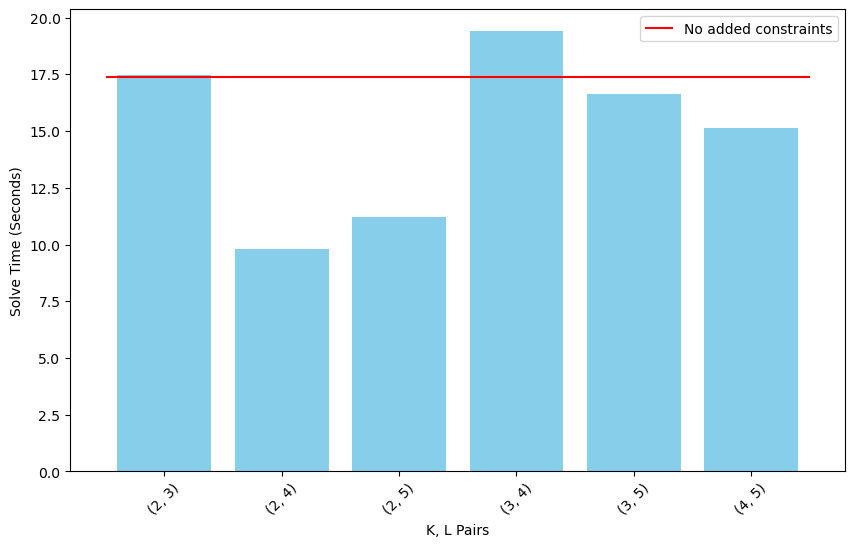

In [ ]:
# Convert pairs to string format for labeling
pairs_2 = [(2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
pair_labels = [f"({card}, {l})" for card, l in pairs_2]

# Plotting computational time
plt.figure(figsize=(10, 6))
plt.bar(pair_labels, solve_time_q3, color='skyblue')
plt.hlines(No_cardinality, xmin=-0.5, xmax=len(pair_labels)-0.5, colors='red', label='No added constraints')
plt.xlabel('K, L Pairs')
plt.ylabel('Solve Time (Seconds)')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.legend()
plt.show()

# Fractional

In [ ]:
# Looping through different cardinality constraints
pairs = [(3.2, 3), (3.2, 4), (3.2, 5), (3.3, 4), (3.3, 5), (3.4, 5)]
solve_time_q3_frac = list()
iter_q3_frac = list()
objective_list_q3_frac = list()
nrows_list_q3_frac = list()

for cardinality, l in pairs:
    solver = TspFractionalBCSolver(instance=i, cardinality=cardinality, len = l)
    solution = solver.solve()

    if solution == 'Solution not found':
        solve_time_q3.append(0)
        iter_q3.append(0)
        objective_list_q3_frac.append(0)
        nrows_list_q3_frac.append(0)
    else:
        solve_time_q3_frac.append(solver._model.Runtime)
        iter_q3_frac.append(solution.model_metrics['IterCount'])
        objective_list_q3_frac.append(solver._model.ObjVal)
        nrows_list_q3_frac.append(solver._model.NumConstrs)

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2215 rows, 195806 columns and 394270 nonzeros
Model fingerprint: 0x5c03eefe
Variable types: 0 continuous, 195806 integer (195806 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Separation round!
	Found a subset which violate a SEC (flow = 0.000 < 1)
	Set size: 320
Presolve removed 14 rows and 0 columns
Presolve time: 0.22s
Presolved: 2201 rows, 195806 columns, 394242 nonzeros
Variable types: 0 continuous, 195806 integer (195806 binary)
Separation round!
	Found a subset which violate a SEC (flow = 0.000 < 1)
	Set size: 441
Root relaxation presolved: 2202 rows, 195806 columns, 394244 nonzeros

Deterministic concurrent LP optimizer: primal and dual sim

### Graph

In [ ]:
# Convert pairs to string format for labeling
pairs_2 = [(2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
pair_labels = [f"({card}, {l})" for card, l in pairs_2]

# Plotting computational time
plt.figure(figsize=(10, 6))
plt.bar(pair_labels, solve_time_q3_frac, color='skyblue')
plt.xlabel('K, L Pairs')
plt.ylabel('Solve Time (Seconds)')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

### Table

In [ ]:
int_q3 = pd.DataFrame({'time': solve_time_q3, 'obj': objective_list_q3, 'rows': nrows_list_q3, 'iter': iter_q3})
int_q3['type'] = 'integer'

frac_q3 = pd.DataFrame({'time': solve_time_q3_frac, 'obj': objective_list_q3_frac, 'rows': nrows_list_q3_frac, 'iter': iter_q3_frac})
frac_q3['type'] = 'integer'



pd.concat([int_q3, frac_q3], axis='rows').to_csv('question 3')

latex_table_temp = pd.concat([int_q3, frac_q3], axis='rows')
latex_table_3_frac = latex_table_temp.to_latex(index = False)